In [1]:
import os
import io
import re
import random
import argparse
import numpy as np
import torch
from fairseq import utils

parser = argparse.ArgumentParser(description='Options')
parser.add_argument('-split', default='val', type=str, choices=['val', 'test_seen', 'test_seen_cluttered', 'test_unseen'])
parser.add_argument('-q_path', default='q_gen.pt', help='path of the pre-trained questioner model')
parser.add_argument('-a_path', default='a_int.pt', help='path of the pre-trained answerer model')
parser.add_argument('-vg_path', default='vg.pt', help='path of the pre-trained visual grounding model')
parser.add_argument('-baseline', action='store_true', help='run the baseline method (vg-only)')
parser.add_argument('-seed', default=7, type=int, help='fixed seed for deterministic decoding')
parser.add_argument('-beam_size', default=5, type=int, help='beam size of decoding')
parser.add_argument('-lambda', default=0.9, type=float, help='rationality')
parser.add_argument('-max_round', default=2, type=int, help='maximum number of interaction')
parser.add_argument('-gpu', default=1, type=int, help='ids of GPUs to use')
parser.add_argument('-use_fp16', default=False)
params = vars(parser.parse_args(args=[]))

# GPUs
gpu_num = params['gpu']
device = torch.device(f'cuda:{gpu_num}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

# fix seed 
np.random.seed(params['seed'])
utils.set_torch_seed(params['seed'])
random.seed(params['seed'])

In [2]:
import pandas as pd
import base64
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from torch import nn
from fairseq import tasks
from fairseq import checkpoint_utils
from utils.eval_utils import eval_step

from tasks.mm_tasks.questioner import questionerTask
from tasks.mm_tasks.answerer import answererTask
from tasks.mm_tasks.progrounding import progroundingTask
from models.ofa import OFAModel
from PIL import Image
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from sklearn.metrics import f1_score


class PRoGrasp(nn.Module):
    def __init__(self, params):
        super(PRoGrasp, self).__init__()
        self.params = params
        self.split = self.params['split']

        ####################################################
        # default setting
        ####################################################
        assert self.params['q_path'] and self.params['a_path'] and self.params['vg_path'] 
        self.use_cuda = torch.cuda.is_available()
        overrides={"bpe_dir":"utils/BPE"}

        ####################################################
        # questioner build and load
        ####################################################
        tasks.register_task('questioner', questionerTask)        
        self.q_models, self.q_cfg, self.q_task = checkpoint_utils.load_model_ensemble_and_task(
            utils.split_paths(self.params['q_path']),
            arg_overrides=overrides
        )

        self.q_cfg.common.seed = self.params['seed']
        self.q_cfg.generation.beam = self.params['beam_size']
        self.q_cfg.generation.min_len = 1
        self.q_cfg.generation.max_len_a = 0
        self.q_cfg.generation.max_len_b = 16
        self.q_cfg.generation.no_repeat_ngram_size = 3
        self.load_model(self.q_models, self.q_cfg, self.params['use_fp16'], self.use_cuda)
        self.q_generator = self.q_task.build_generator(self.q_models, self.q_cfg.generation)
        
        # question scorer
        self.q_cfg.generation.score_reference = True
        self.q_scorer = self.q_task.build_generator(self.q_models, self.q_cfg.generation)   
        print('load ' + self.q_task.cfg._name + ' done ...')

        ####################################################
        # answerer build and load 
        ####################################################
        tasks.register_task('answerer', answererTask)
        self.a_models, self.a_cfg, self.a_task = checkpoint_utils.load_model_ensemble_and_task(
            utils.split_paths(self.params['a_path']),
            arg_overrides=overrides
        )

        self.a_cfg.common.seed = self.params['seed']
        self.a_cfg.generation.beam = self.params['beam_size']
        self.a_cfg.generation.min_len = 1
        self.a_cfg.generation.max_len_a = 0
        self.a_cfg.generation.max_len_b = 16
        self.a_cfg.generation.no_repeat_ngram_size = 3

        # answer generator
        self.load_model(self.a_models, self.a_cfg, self.params['use_fp16'], self.use_cuda)
        self.a_generator = self.a_task.build_generator(self.a_models, self.a_cfg.generation) 

        # answer scorer
        self.a_cfg.generation.score_reference = True
        self.a_scorer = self.a_task.build_generator(self.a_models, self.a_cfg.generation)
        print('load ' + self.a_task.cfg._name + ' done ...')

        ####################################################
        # build and load visual grounding
        ####################################################
        tasks.register_task('progrounding', progroundingTask)
        self.vg_models, self.vg_cfg, self.vg_task = checkpoint_utils.load_model_ensemble_and_task(
            utils.split_paths(self.params['vg_path']),
            arg_overrides=overrides
        )

        self.vg_cfg.common.seed = self.params['seed']
        self.vg_cfg.generation.beam = self.params['beam_size']
        self.vg_cfg.generation.min_len = 4
        self.vg_cfg.generation.max_len_a = 0
        self.vg_cfg.generation.max_len_b = 20
        self.vg_cfg.generation.no_repeat_ngram_size = 3

        # visual grounding model
        self.load_model(self.vg_models, self.vg_cfg, self.params['use_fp16'], self.use_cuda)
        self.vg_generator = self.vg_task.build_generator(self.vg_models, self.vg_cfg.generation)

        # visual grounding scorer
        self.vg_cfg.generation.score_reference = True
        self.vg_scorer = self.vg_task.build_generator(self.vg_models, self.vg_cfg.generation)
        print('load ' + self.vg_task.cfg._name + ' done ...')

        # image transformation
        self.patch_image_size = self.a_cfg.task.patch_image_size
        self.patch_resize_transform = transforms.Compose([
            lambda image: image.convert("RGB"),
            transforms.Resize((self.patch_image_size, self.patch_image_size), interpolation=InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
        self.IMAGE_WIDTH = 640
        self.IMAGE_HEIGHT = 480
        self.NUM_BINS = 1000

        # text
        self.bos_item = torch.LongTensor([self.a_task.src_dict.bos()])
        self.eos_item = torch.LongTensor([self.a_task.src_dict.eos()])
        self.pad_idx = self.a_task.src_dict.pad()
        self.max_src_length = 80


    def load_model(self, models, cfg, use_fp16=False, use_cuda=True):
        for model in models:
            model.eval()
            if use_fp16:
                model.half()
            if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
                model.cuda()
            model.prepare_for_inference_(cfg)

    def encode_text(self, text, task, length=None, append_bos=False, append_eos=False, use_bpe=True):
        s = task.tgt_dict.encode_line(
            line=task.bpe.encode(text) if use_bpe else text,
            add_if_not_exist=False,
            append_eos=False
        ).long()
        if length is not None:
            s = s[:length]
        if append_bos:
            s = torch.cat([self.bos_item, s])
        if append_eos:
            s = torch.cat([s, self.eos_item])
        return s

    def pre_caption(self, caption, max_words=None):
        caption = caption.lower().lstrip(",.!?*#:;~").replace('-', ' ').replace('/', ' ').replace('<person>', 'person')

        caption = re.sub(
            r"\s{2,}",
            ' ',
            caption,
        )
        caption = caption.rstrip('\n')
        caption = caption.strip(' ')

        # truncate caption
        caption_words = caption.split(' ')
        if max_words is not None and len(caption_words) > max_words:
            caption = ' '.join(caption_words[:max_words])

        return caption

    def apply_half(self, t):
        # Function to turn FP32 to FP16
        if t.dtype is torch.float32:
            return t.to(dtype=torch.half)
        return t

    def calculate_ap_score(self, hyps, refs, thresh=0.9):
        interacts = torch.cat(
            [torch.where(hyps[:, :2] < refs[:, :2], refs[:, :2], hyps[:, :2]),
             torch.where(hyps[:, 2:] < refs[:, 2:], hyps[:, 2:], refs[:, 2:])],
            dim=1
        )
        area_predictions = (hyps[:, 2] - hyps[:, 0]) * (hyps[:, 3] - hyps[:, 1])
        area_targets = (refs[:, 2] - refs[:, 0]) * (refs[:, 3] - refs[:, 1])
        interacts_w = interacts[:, 2] - interacts[:, 0]
        interacts_h = interacts[:, 3] - interacts[:, 1]
        area_interacts = interacts_w * interacts_h
        ious = area_interacts / (area_predictions + area_targets - area_interacts + 1e-6)
        return ((ious >= thresh) & (interacts_w > 0) & (interacts_h > 0)).float()


    def construct_sample(self, image, region_coord, context, model, target=None):
        w_resize_ratio = torch.tensor(self.patch_image_size / self.IMAGE_WIDTH).unsqueeze(0)
        h_resize_ratio = torch.tensor(self.patch_image_size / self.IMAGE_HEIGHT).unsqueeze(0)

        if model == 'vg': 
            patch_image = self.patch_resize_transform(image).unsqueeze(0)
            patch_mask = torch.tensor([True])

            context_list = context.split('/')
            prompt = ' which regions does the dialogue " {} " describe?'
            source = ''
            for idx, utt in enumerate(context_list):
                if idx == 0: # instruction
                    source += 'initial instruction is "' + utt + '"'
                elif idx % 2 == 1: # question
                    source += ' questioner asks "' + utt + '"'
                else: # answer
                    source += ' answerer says "' + utt + '"'

            src_caption = self.pre_caption(source, self.max_src_length)
            src_text = self.encode_text(prompt.format(src_caption), self.vg_task)
            src_text = torch.cat([self.bos_item, src_text, self.eos_item])
            src_text = src_text.unsqueeze(0)
            src_length = torch.LongTensor([s.ne(self.pad_idx).long().sum() for s in src_text])
            sample = {
                "id":np.array(['40']),
                "net_input": {
                    "src_tokens": src_text,
                    "src_lengths": src_length,
                    "patch_images": patch_image,
                    "patch_masks": patch_mask,
                },
                "w_resize_ratios": w_resize_ratio,
                "h_resize_ratios": h_resize_ratio,
                "region_coords": torch.randn(1, 4)
            }

            if target:
                boxes_target = {"boxes": [], "labels": [], "area": [], "size": torch.tensor([self.IMAGE_HEIGHT, self.IMAGE_WIDTH])}
                x0, y0, x1, y1 = target[0], target[1], target[2], target[3]
                boxes_target["boxes"] = torch.tensor([[float(x0), float(y0), float(x1), float(y1)]])
                boxes_target["labels"] = np.array([0])
                boxes_target["area"] = torch.tensor([(float(x1) - float(x0)) * (float(y1) - float(y0))])

                quant_x0 = "<bin_{}>".format(int((boxes_target["boxes"][0][0]/self.IMAGE_WIDTH * (self.NUM_BINS - 1)).round()))
                quant_y0 = "<bin_{}>".format(int((boxes_target["boxes"][0][1]/self.IMAGE_HEIGHT * (self.NUM_BINS - 1)).round()))
                quant_x1 = "<bin_{}>".format(int((boxes_target["boxes"][0][2]/self.IMAGE_WIDTH * (self.NUM_BINS - 1)).round()))
                quant_y1 = "<bin_{}>".format(int((boxes_target["boxes"][0][3]/self.IMAGE_HEIGHT * (self.NUM_BINS - 1)).round()))
                region_coord = "{} {} {} {}".format(quant_x0, quant_y0, quant_x1, quant_y1)
                tgt_item = self.encode_text(region_coord, self.vg_task, use_bpe=False)

                target_item = torch.cat([tgt_item, self.eos_item])
                prev_output_item = torch.cat([self.bos_item, tgt_item])

                target_item = target_item.unsqueeze(0)
                prev_output_item = prev_output_item.unsqueeze(0)
                sample['target'] = target_item
                sample['net_input']['prev_output_tokens'] = prev_output_item
            return sample

        elif model == 'q':
            boxes_target = {"boxes": [], "labels": [], "area": [], "size": torch.tensor([self.IMAGE_HEIGHT, self.IMAGE_WIDTH])}
            x0, y0, x1, y1 = region_coord[0], region_coord[1], region_coord[2], region_coord[3] 
            boxes_target["boxes"] = torch.tensor([[float(x0), float(y0), float(x1), float(y1)]])
            boxes_target["labels"] = np.array([0])
            boxes_target["area"] = torch.tensor([(float(x1) - float(x0)) * (float(y1) - float(y0))])
            patch_image = self.patch_resize_transform(image).unsqueeze(0)
            patch_mask = torch.tensor([True])

            quant_x0 = "<bin_{}>".format(int((boxes_target["boxes"][0][0]/self.IMAGE_WIDTH * (self.NUM_BINS - 1)).round()))
            quant_y0 = "<bin_{}>".format(int((boxes_target["boxes"][0][1]/self.IMAGE_HEIGHT * (self.NUM_BINS - 1)).round()))
            quant_x1 = "<bin_{}>".format(int((boxes_target["boxes"][0][2]/self.IMAGE_WIDTH * (self.NUM_BINS - 1)).round()))
            quant_y1 = "<bin_{}>".format(int((boxes_target["boxes"][0][3]/self.IMAGE_HEIGHT * (self.NUM_BINS - 1)).round()))
            region_coord = "{} {} {} {}".format(quant_x0, quant_y0, quant_x1, quant_y1)
            coord_item = self.encode_text(region_coord, self.q_task, use_bpe=False)

            prompt = ' given the dialogue history " {} ", what can I ask about the region? '
            context_list = context.split('/')
            source = ''
            for idx, utt in enumerate(context_list):
                if idx == 0: # instruction
                    source += 'initial instruction is "' + utt + '"'
                elif idx % 2 == 1: # question
                    source += ' questioner asks "' + utt + '"'
                else: # answer
                    source += ' answerer says "' + utt + '"'

            src_text = self.encode_text(prompt.format(source), self.q_task)
            src_text = torch.cat([self.bos_item, src_text, coord_item, self.eos_item])
            src_text = src_text.unsqueeze(0)
            src_length = torch.LongTensor([s.ne(self.pad_idx).long().sum() for s in src_text])
            sample = {
                "id":np.array(['40']),
                "net_input": {
                    "src_tokens": src_text,
                    "src_lengths": src_length,
                    "patch_images": patch_image,
                    "patch_masks": patch_mask,
                },
                "w_resize_ratios": w_resize_ratio,
                "h_resize_ratios": h_resize_ratio,
                "region_coords": torch.randn(1, 4)
            }
            return sample

        else: # answerer
            boxes_target = {"boxes": [], "labels": [], "area": [], "size": torch.tensor([self.IMAGE_HEIGHT, self.IMAGE_WIDTH])}
            x0, y0, x1, y1 = region_coord[0], region_coord[1], region_coord[2], region_coord[3]
            boxes_target["boxes"] = torch.tensor([[float(x0), float(y0), float(x1), float(y1)]])
            boxes_target["labels"] = np.array([0])
            boxes_target["area"] = torch.tensor([(float(x1) - float(x0)) * (float(y1) - float(y0))])
            patch_image = self.patch_resize_transform(image).unsqueeze(0)
            patch_mask = torch.tensor([True])

            quant_x0 = "<bin_{}>".format(int((boxes_target["boxes"][0][0]/self.IMAGE_WIDTH * (self.NUM_BINS - 1)).round()))
            quant_y0 = "<bin_{}>".format(int((boxes_target["boxes"][0][1]/self.IMAGE_HEIGHT * (self.NUM_BINS - 1)).round()))
            quant_x1 = "<bin_{}>".format(int((boxes_target["boxes"][0][2]/self.IMAGE_WIDTH * (self.NUM_BINS - 1)).round()))
            quant_y1 = "<bin_{}>".format(int((boxes_target["boxes"][0][3]/self.IMAGE_HEIGHT * (self.NUM_BINS - 1)).round()))

            region_coord = "{} {} {} {}".format(quant_x0, quant_y0, quant_x1, quant_y1)
            coord_item = self.encode_text(region_coord, self.a_task, use_bpe=False)

            prompt = ' does the question " {}? " describe the region? region: '
            src_text = self.encode_text(prompt.format(context), self.a_task)
            src_text = torch.cat([self.bos_item, src_text, coord_item, self.eos_item])
            src_text = src_text.unsqueeze(0)
            src_length = torch.LongTensor([s.ne(self.pad_idx).long().sum() for s in src_text])
            sample = {
                "id":np.array(['40']),
                "net_input": {
                    "src_tokens": src_text,
                    "src_lengths": src_length,
                    "patch_images": patch_image,
                    "patch_masks": patch_mask,
                },
                "w_resize_ratios": w_resize_ratio,
                "h_resize_ratios": h_resize_ratio,
                "region_coords": torch.randn(1, 4)
            }

            if target:
                tgt_text = self.encode_text(target, self.a_task)
                target_item = torch.cat([tgt_text, self.eos_item])
                prev_output_item = torch.cat([self.bos_item, tgt_text])

                target_item = target_item.unsqueeze(0)
                prev_output_item = prev_output_item.unsqueeze(0)
                sample['target'] = target_item
                sample['net_input']['prev_output_tokens'] = prev_output_item
            return sample


    def forward(self, image, context, model, bbox=None, target=None):
        sample = self.construct_sample(image, bbox, context, model, target)
        sample = utils.move_to_cuda(sample) if self.use_cuda else sample
        sample = utils.apply_to_sample(apply_half, sample) if self.params['use_fp16'] else sample
        with torch.no_grad():
            if target:
                _, score = eval_step(getattr(self, model+'_task'), getattr(self, model+'_scorer'), getattr(self, model+'_models'), sample)
                return torch.exp(score).item()
            else:
                result, _ = eval_step(getattr(self, model+'_task'), getattr(self, model+'_generator'), getattr(self, model+'_models'), sample)
                return result[0]['result']

In [3]:
# init module
prograsp = PRoGrasp(params)
gt = []
pred = []
al = []

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


2024-02-28 19:53:06 | INFO | tasks.ofa_task | source dictionary: 59457 types
2024-02-28 19:53:06 | INFO | tasks.ofa_task | target dictionary: 59457 types


load questioner done ...


2024-02-28 19:54:12 | INFO | tasks.ofa_task | source dictionary: 59457 types
2024-02-28 19:54:12 | INFO | tasks.ofa_task | target dictionary: 59457 types


load answerer done ...


2024-02-28 19:55:23 | INFO | tasks.ofa_task | source dictionary: 59457 types
2024-02-28 19:55:23 | INFO | tasks.ofa_task | target dictionary: 59457 types


load progrounding done ...


In [4]:
# image visualization
import cv2
from matplotlib import pyplot as plt

def visualize(image=None, text=None, gt_bbox=None, pred_bbox=None):
    if image:
        img = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2BGR)
        if gt_bbox:
            cv2.rectangle(
                img,
                (int(gt_bbox[0]), int(gt_bbox[1])),
                (int(gt_bbox[2]), int(gt_bbox[3])),
                (0, 0, 255),
                3
            )
        if pred_bbox:
            num_cands = len(pred_bbox) // 4
            for c in range(num_cands):
                cand_bbox = pred_bbox[c*4:(c+1)*4]
                cv2.rectangle(
                    img,
                    (int(cand_bbox[0]), int(cand_bbox[1])),
                    (int(cand_bbox[2]), int(cand_bbox[3])),
                    (0, 255, 0),
                    3
                )
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.show()
    if text:
        text_list = text.split('/')
        for idx, utt in enumerate(text_list):
            if idx % 2 == 1:
                utt = "PRoGrasp: "+utt+"?"
            else:
                utt = "User: "+utt    
            print(utt)    

In [5]:
from IPython.display import clear_output
def clearout():
    for i in range(50):
        clear_output(wait=True)

----------------------------------------------------
Dialogue #0
----------------------------------------------------


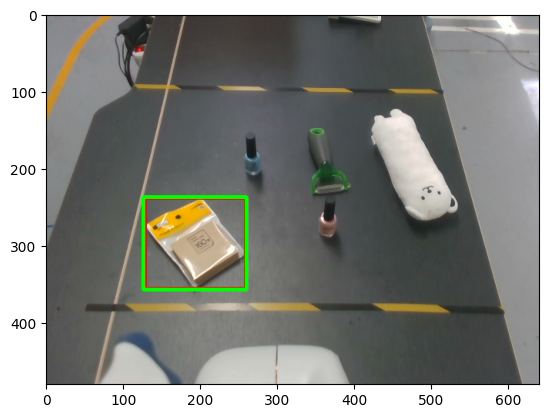

User: i should leave a memo to my friend


In [ ]:
import json
import torch
import torch.nn.functional as F

params['split'] = 'test_seen'
tsv_path = 'data/preprocessed/{}_common.tsv'.format(params['split'])

params['baseline'] = False
params['max_round'] = 2
gt = []
pred = []

with open(tsv_path, 'r') as f:
    for cnt, tr in enumerate(pd.read_csv(f, chunksize=1, delimiter='\t', keep_default_na=False, header=None)):
        for i, row in tr.iterrows():
            gt_bbox = row[2]
            full_context = row[3]
            imagestring = row[4]
            imgdata = base64.b64decode(imagestring)
            image = Image.open(io.BytesIO(imgdata))

            if params['baseline']:
                """
                SilentGrasp
                """
                full_context = full_context.split('/')[0]
                x0, y0, x1, y1 = gt_bbox.strip().split(',')
                gt_bbox = [float(x0), float(y0), float(x1), float(y1)]
                pred_bbox = prograsp(image=image, context=full_context, model='vg')

                if len(pred_bbox) > 4:
                    # multi-bbox prediction
                    cand_bbox_scores = []
                    num_cands = len(pred_bbox) // 4
                    for c in range(num_cands):
                        cand_bbox = pred_bbox[c*4:(c+1)*4]
                        cand_bbox_vg_score = prograsp(image=image, context=full_context, model='vg', target=cand_bbox)
                        cand_bbox_scores.append(cand_bbox_vg_score) 

                    cand_bbox_scores = np.array(cand_bbox_scores)
                    max_ind = np.argmax(cand_bbox_scores)
                    pred_bbox = pred_bbox[max_ind*4:(max_ind+1)*4]
                    pred_bbox_score = cand_bbox_scores[max_ind]

                gt.append(torch.tensor(gt_bbox))
                pred.append(torch.tensor(pred_bbox).float())
            else:
                """
                PRoGrasp (ours)
                """                
                print('----------------------------------------------------')
                print('Dialogue #{}'.format(str(i)))
                print('----------------------------------------------------')
                
                context = full_context.split('/')[0] # initial instruction
                x0, y0, x1, y1 = gt_bbox.strip().split(',')
                gt_bbox = [float(x0), float(y0), float(x1), float(y1)]
                pred_bbox = []                

                for rnd in range(params['max_round']):
                    new_pred_bbox = prograsp(image=image, context=context, model='vg')
                    pred_bbox.extend(new_pred_bbox)
                    num_cands = len(pred_bbox) // 4
                    
                    visualize(image=image, text=context, gt_bbox=gt_bbox, pred_bbox=pred_bbox)
                    
                    cand_bbox_idx = random.randrange(0, num_cands)
                    cand_bbox_for_question = pred_bbox[cand_bbox_idx*4:(cand_bbox_idx+1)*4]
                    question = prograsp(image=image, context=context, model='q', bbox=cand_bbox_for_question)
                    answer = input("PROGrasp: "+question+"?\nUser: ")
                    
                    context += '/{}'.format(question)
                    context += '/{}'.format(answer)
                    
                    cand_bbox_scores = []
                    for c in range(num_cands):
                        cand_bbox = pred_bbox[c*4:(c+1)*4]
                        cand_bbox_a_score = prograsp(image=image, context=question, model='a', bbox=cand_bbox, target=answer)
                        cand_bbox_vg_score = prograsp(image=image, context=context, model='vg', target=cand_bbox)
                        cand_bbox_score = (cand_bbox_a_score ** (params['lambda'])) * (cand_bbox_vg_score ** (1-params['lambda']))
                        cand_bbox_scores.append(cand_bbox_score)

                    cand_bbox_scores = torch.tensor(cand_bbox_scores).float()
                    cand_bbox_scores = F.softmax(cand_bbox_scores, dim=0)
                    cand_bbox_scores = cand_bbox_scores.numpy()
                    
                    selected_ind = np.argmax(cand_bbox_scores)
                    selected_bbox = pred_bbox[selected_ind*4:(selected_ind+1)*4]
                    pred_bbox_score = cand_bbox_scores[selected_ind]

                gt.append(torch.tensor(gt_bbox))
                pred.append(torch.tensor(selected_bbox).float())

                visualize(image=image, text=context, gt_bbox=gt_bbox, pred_bbox=selected_bbox)
                print('final object selected')

gt = torch.stack(gt, dim=0)
pred = torch.stack(pred, dim=0)

ret1 = prograsp.calculate_ap_score(pred, gt, thresh=0.5)
ret_ret1 = torch.mean(ret1).item()
print(ret_ret1)

ret2 = prograsp.calculate_ap_score(pred, gt, thresh=0.9)
ret_ret2 = torch.mean(ret2).item()
print(ret_ret2)